In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

import pickle

from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline

ham = gp.Hamiltonian(gp.MilkyWayPotential())

coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

In [2]:
plt.style.use('notebook')

## Define coordinate system

### Fit Ibata sky positions

In [3]:
dib = Table.read('../data/ylgr_b_l.csv', names=('l', 'b'), data_start=0)

In [4]:
dib

l,b
float64,float64
-66.2623934389615,24.535099156377555
-66.89160535556962,24.320836269100027
-67.13879575137996,26.30457356254584
-67.93429938880595,26.038791284394847
-67.83542323048182,24.05120207387438
-68.17250104295047,27.437037182493555
-68.40364011435754,26.172507834272068
-68.92370302502344,26.72553307141854
-69.45589360301626,27.44088909956821


In [5]:
cib_gal = coord.Galactic(l=dib['l']*u.deg, b=dib['b']*u.deg)

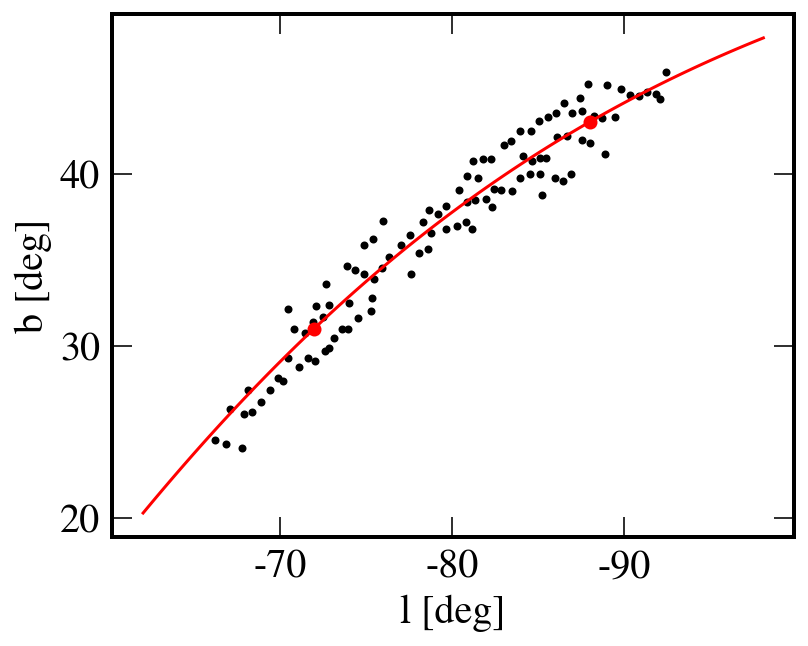

In [6]:
lend = np.array([-72, -88])*u.deg
bend = np.array([31., 43.])*u.deg
cend = coord.SkyCoord(l=lend, b=bend, frame=coord.Galactic)

pole = gc.pole_from_endpoints(cend[0], cend[1])
fr = gc.GreatCircleICRSFrame(pole=pole, rotation=63*u.deg)

c0 = coord.SkyCoord(phi1=np.linspace(-20,20,100)*u.deg, phi2=np.zeros(100)*u.deg, frame=fr)
c0_gal = c0.transform_to(coord.Galactic)

plt.figure(figsize=(6,6))
plt.plot(cib_gal.l.wrap_at(180*u.deg), cib_gal.b, 'k.')
plt.plot(cend.l.wrap_at(180*u.deg), cend.b, 'ro')
plt.plot(c0_gal.l.wrap_at(180*u.deg), c0_gal.b, 'r-')

# plt.xlim(-60,-100)
# plt.ylim(30,70)
# plt.ylim()
plt.gca().invert_xaxis()
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')

plt.gca().set_aspect('equal')
plt.tight_layout()

In [7]:
cib = cib_gal.transform_to(fr)

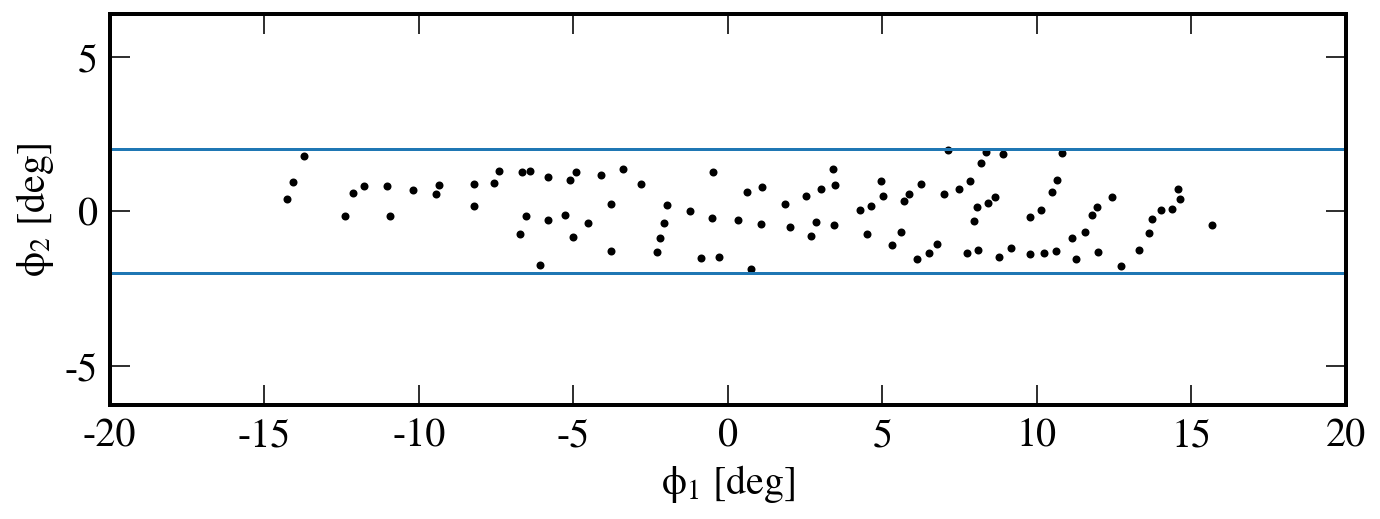

In [10]:
plt.figure(figsize=(10,4))
plt.plot(cib.phi1, cib.phi2, 'k.')

plt.axhline(-2)
plt.axhline(2)

plt.xlim(-20,20)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

In [11]:
fr.pole, fr.rotation

(<ICRS Coordinate: (ra, dec, distance) in (deg, deg, )
     (73.82617395, -22.94518097, 1.)>,
 <Quantity 63. deg>)

In [12]:
pickle.dump(fr, open('../data/ylgr_frame.pkl', 'wb'))

## Create $Gaia$ query

In [13]:
ymin, ymax = -10, 10
corners = [np.array([[-20, ymin], [-20,ymax], [-10,ymax], [-10,ymin]]),
           np.array([[-10, ymin], [-10,ymax], [0,ymax], [0,ymin]]),
           np.array([[0, ymin], [0,ymax], [10,ymax], [10,ymin]]),
           np.array([[10, ymin], [10,ymax], [20,ymax], [20,ymin]]),
           ]

In [14]:
for corner in corners:
    c_corner = coord.SkyCoord(phi1=corner[:,0]*u.deg, phi2=corner[:,1]*u.deg, frame=fr)
    ceq_corner = c_corner.transform_to(coord.ICRS)
    q_base ='''SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.phot_g_mean_flux_over_error, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.ag_gspphot, gaia.ebpminrp_gspphot, gaia.radial_velocity, gaia.radial_velocity_error FROM gaiadr3.gaia_source as gaia
WHERE parallax -2*parallax_error< 0.2 AND ruwe < 1.4 AND visibility_periods_used>5 AND pmdec<0 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {0.ra.degree}, {0.dec.degree}, 
                       {1.ra.degree}, {1.dec.degree}, 
                       {2.ra.degree}, {2.dec.degree}, 
                       {3.ra.degree}, {3.dec.degree})) = 1
'''
    print(corner)
    print(q_base.format(ceq_corner[3], ceq_corner[2], ceq_corner[1], ceq_corner[0]))

[[-20 -10]
 [-20  10]
 [-10  10]
 [-10 -10]]
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.phot_g_mean_flux_over_error, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.ag_gspphot, gaia.ebpminrp_gspphot, gaia.radial_velocity, gaia.radial_velocity_error FROM gaiadr3.gaia_source as gaia
WHERE parallax -2*parallax_error< 0.2 AND ruwe < 1.4 AND visibility_periods_used>5 AND pmdec<0 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       190.2576674375041, -28.56021421698596, 
                       168.99490205034402, -37.84124114716407, 
                       174.0287661524511, -46.96632389291064, 
                       197.09710828000547, -36.55250351865717)) = 1

[[-10 -10]
 [-10  10]
 [  0  10]
 [  0 -10]]
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_over_err